######LightBGM<p>
    <span style="background-color: #FFFF00">[説明変数]</span> 調整後始値、調整後高値、調整後安値、調整後終値、出来高、単純移動平均、移動平均乖離率、RSI、BB、MACD、VR、騰落レシオ、曜日、ADX、ATR、国債金利</p>
    <p><span style="background-color:#FFFF00">[目的変数]</span> 翌日の始値から3日後の始値が3%以上上がった・下がった</p>
    <p><span style="background-color:#FFFF00">[学習モデル] </span>勾配ブースティング（LightGBM）</p>
    <p><span style="background-color: #FFFF00">[モデル評価]</span> 5分割StratifiedKFold（層状K分割）</p>

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error  # モデル評価用(平均二乗誤差)
from sklearn.model_selection import train_test_split  # データセット分割用
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import matplotlib as mpl
import pandas_datareader.data as web
import warnings  # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
import lightgbm as lgb  # LightGBM
from sklearn import linear_model
import pymc3 as pm
import pandas.util.testing as tm

In [4]:
l = [9202]

df = web.DataReader([str(c) + '.JP' for c in l], 'stooq')

In [25]:
df1_Close=df[:-1216:-1]["Close"]
df1_Close_3=df[-4::-1]["Close"]
print(df1_Close,df1_Close_3)

Symbols     9202.JP
Date               
2016-01-04  3081.92
2016-01-05  3080.97
2016-01-06  3073.70
2016-01-07  3034.42
2016-01-08  3008.83
...             ...
2020-12-18  2247.00
2020-12-21  2202.50
2020-12-22  2151.00
2020-12-23  2155.50
2020-12-24  2183.50

[1215 rows x 1 columns] Symbols     9202.JP
Date               
2016-01-07  3034.42
2016-01-08  3008.83
2016-01-12  2929.24
2016-01-13  3045.38
2016-01-14  3025.17
...             ...
2020-12-23  2155.50
2020-12-24  2183.50
2020-12-25  2180.00
2020-12-28  2148.50
2020-12-29  2250.00

[1215 rows x 1 columns]


In [31]:
Y = [(df1_Close_3.values[i][0]-df1_Close.values[i][0])/df1_Close.values[i][0]
     for i in range(1215)]

In [35]:
Y_signal=[]
for i in Y:
    if i >0.03:
        dum:int=1
        Y_signal.append(dum)
    elif i<-0.03:
        dum:int=-1
        Y_signal.append(dum)
    else:
        dum:int=0
        Y_signal.append(dum)

In [36]:
#目的変数
Y_signal

[0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 -1,
 -1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 -1,
 -1,
 -1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 -1,
 0,
 0,
 1,
 0,
 0,
 -1,
 0,
 -1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

In [37]:
#説明変数
df_jpstock=web.DataReader("^_JP","stooq")

In [48]:
df_jpstock=df_jpstock[::-1]

In [46]:
df_usdjpy=web.DataReader('DEXJPUS', 'fred')

In [47]:
df_usdjpy

,DEXJPUS
DATE,
2016-01-04,119.30
2016-01-05,118.95
2016-01-06,118.54
2016-01-07,118.00
2016-01-08,117.74
...,...
2020-12-17,103.13
2020-12-18,103.35
2020-12-21,103.44


1181

In [52]:
df=df[::-1]

In [53]:
df

Attributes,Close,High,Low,Open,Volume
Symbols,9202.JP,9202.JP,9202.JP,9202.JP,9202.JP
Date,,,,,
2016-01-04,3081.92,3133.94,3074.55,3128.48,3287752
2016-01-05,3080.97,3107.50,3052.65,3070.97,1787480
2016-01-06,3073.70,3125.82,3050.86,3100.23,1451911
2016-01-07,3034.42,3112.98,3034.42,3075.50,2050947
2016-01-08,3008.83,3063.60,2997.88,3016.11,2014621
...,...,...,...,...,...
2020-12-23,2155.50,2174.00,2150.00,2153.00,3821600
2020-12-24,2183.50,2203.00,2153.00,2153.00,4006700


In [75]:
df1_Close=df1_Close[29:-1:]

In [76]:
df1_Close_3=df1_Close_3[29:-1:]

In [81]:
Y = [(df1_Close_3.values[i][0]-df1_Close.values[i][0])/df1_Close.values[i][0]
     for i in range(1185)]
Y_signal=[]
for i in Y:
    if i >0.03:
        dum:int=1
        Y_signal.append(dum)
    elif i<-0.03:
        dum:int=-1
        Y_signal.append(dum)
    else:
        dum:int=0
        Y_signal.append(dum)

In [82]:
Y_signal=np.array(Y_signal)

In [90]:
df4=df[29:-4:]
df4

Attributes,Close,High,Low,Open,Volume
Symbols,9202.JP,9202.JP,9202.JP,9202.JP,9202.JP
Date,,,,,
2016-02-16,2833.31,2865.32,2770.23,2801.30,2873733
2016-02-17,2824.24,2884.48,2778.44,2822.36,2357741
2016-02-18,2833.31,2886.28,2822.36,2875.33,2224367
2016-02-19,2896.38,2924.70,2807.72,2824.24,3102954
2016-02-22,2978.62,2983.15,2867.11,2878.91,2624272
...,...,...,...,...,...
2020-12-17,2205.00,2260.00,2200.00,2260.00,7983800
2020-12-18,2247.00,2253.00,2202.00,2205.00,5559600


In [114]:
df_new = pd.DataFrame()
df_new["Y"] = Y_signal
df_new["ANA_High"] = [(i[0]-df4["High"].mean()[0]) /
                      (df4["High"].std()[0]) for i in df4["High"].values]
df_new["ANA_Close"] = [(i[0]-df4["Close"].mean()[0]) /
                       (df4["Close"].std()[0]) for i in df4["Close"].values]
df_new["ANA_Open"] = [(i[0]-df4["Open"].mean()[0]) /
                      (df4["Open"].std()[0]) for i in df4["Open"].values]

In [103]:
volume_std=df4["Volume"].std()[0]
volume_mean=df4["Volume"].mean()[0]

In [112]:
volume_norm=[(i[0]-volume_mean)/(volume_std) for i in df4["Volume"].values]

In [116]:
df_new["volume_norm"]=volume_norm

In [117]:
df_new

,Y,ANA_High,ANA_Close,ANA_Open,volume_norm
0,0,-0.860539,-0.861011,-0.919786,0.612239
1,1,-0.828012,-0.876263,-0.884271,0.329075
2,1,-0.824956,-0.861011,-0.794943,0.255883
3,0,-0.759732,-0.754949,-0.881101,0.738029
4,0,-0.660504,-0.616651,-0.788906,0.475341
...,...,...,...,...,...
1180,0,-1.888165,-1.917602,-1.832630,3.416511
1181,-1,-1.900049,-1.846974,-1.925382,2.086173
1182,0,-1.898351,-1.921807,-1.855397,1.747415
1183,0,-1.988327,-2.008411,-1.933814,3.355432


In [118]:
df_jpstock

,Open,High,Low,Close,Volume
Date,,,,,
2016-02-16,782.87,790.45,782.87,790.45,3246089421
2016-02-17,790.39,790.39,788.09,788.09,2918951974
2016-02-18,802.73,805.37,802.73,805.37,2706505785
2016-02-19,800.43,800.43,800.08,800.08,2380290026
2016-02-22,799.03,808.35,799.03,808.35,2130151641
...,...,...,...,...,...
2020-12-23,1203.22,1203.47,1203.22,1203.47,1527096853
2020-12-24,1206.40,1210.81,1206.40,1210.81,1386083026
2020-12-25,1213.52,1214.04,1213.52,1214.04,1192522220


In [145]:
X =df_new.drop(["Y","Y_value"], axis=1)

In [146]:
y=df_new["Y"]

In [147]:
model = linear_model.LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [148]:
model.coef_

array([ 0.57220472, -0.63516303,  0.03598   , -0.03986781])

In [149]:
model.score(X,y)

0.008677347270853786

In [155]:
X =df_new.drop(["Y","Y_value"], axis=1)
y=df_new["Y_value"]
model = linear_model.LinearRegression()
model.fit(X,y)
model.score(X,y)

0.01699039882683684

In [156]:
model.coef_

array([ 0.10534002, -0.05946773, -0.04889262, -0.00360559])

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=2)

In [158]:
# モデルの学習
model = lgb.LGBMRegressor() # モデルのインスタンスの作成
model.fit(X_train, y_train) # モデルの学習

# テストデータの予測
y_pred = model.predict(X_test)

,y_test,y_prediction
1041,-0.046588,-0.026361
862,0.012908,0.008111
511,-0.015980,-0.001275
327,0.009751,0.001491
842,0.011883,0.000250
...,...,...
836,0.011167,-0.001011
451,0.023300,-0.003804
318,0.004533,0.011663
884,-0.004586,0.003762


Text(0.5, 1.0, 'y vs y_pred')

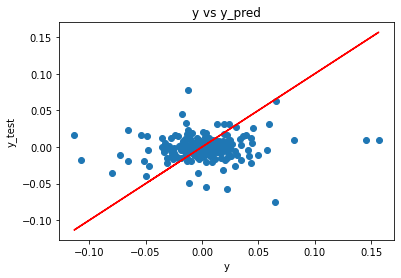

In [159]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'y_test':y_test,'y_prediction':y_pred})
display(df_pred)

# 散布図を描画(真値 vs 予測値)
plt.plot(y_test, y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_test, y_pred) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_test') # y軸ラベル
plt.title('y vs y_pred') # グラフタイトル

In [160]:
# モデル評価
# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

# r2 : 決定係数
r2 = r2_score(y_test,y_pred)
print('R2 :',r2)

RMSE : 0.031137723850558064
R2 : -0.1884248706337066


In [161]:
df_new

,Y,ANA_High,ANA_Close,ANA_Open,volume_norm,Y_value
0,0,-0.860539,-0.861011,-0.919786,0.612239,0.022260
1,1,-0.828012,-0.876263,-0.884271,0.329075,0.054662
2,1,-0.824956,-0.861011,-0.794943,0.255883,0.046119
3,0,-0.759732,-0.754949,-0.881101,0.738029,0.026833
4,0,-0.660504,-0.616651,-0.788906,0.475341,0.006150
...,...,...,...,...,...,...
1180,0,-1.888165,-1.917602,-1.832630,3.416511,-0.024490
1181,-1,-1.900049,-1.846974,-1.925382,2.086173,-0.040721
1182,0,-1.898351,-1.921807,-1.855397,1.747415,-0.008627
1183,0,-1.988327,-2.008411,-1.933814,3.355432,0.013482


In [162]:
model._coef

AttributeError: 'LGBMRegressor' object has no attribute '_coef'